# Analyze the IBD distribion along the genome

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket as socket
import os as os
import sys as sys
import h5py
import matplotlib.cm as cm
import itertools as it
import multiprocessing as mp

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

sys.path.append("./notebook/simulate/python/")  # Assume we are in Hapsburg Root Directory
from load_funcs import Summary_IBD_Calls # To load the simulated IBD calls
#from run import hapBLOCK_chroms

compute-a-16-62.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 32


In [5]:
def load_map(path_h5, map_col="variants/MAP"):
    """Load map positions from hdf5"""
    f = h5py.File(path_h5, "r") # Load for Sanity Check. See below!
    m = f[map_col][:]
    print(f"Loaded {len(m)} map positions")
    return m

def create_counts(df_fp, m, bin_width=0.005):
    """Given a IBD dataframe and recombination map,
    produce a counts array counting how often each bin is hit.
    Return bin edges and counts in each bin.
    bin_width: Width of each bin [in Morgan]"""
    starts = df_fp["StartM"].values
    ends = df_fp["EndM"].values

    ### Create the Binned Statistic
    bins10 = np.arange(min(m), max(m), step=bin_width)  # 0.1 cM Bins
    counts = np.zeros(len(bins10), dtype="int")

    for i in range(len(starts)):
        i1 = np.searchsorted(bins10, starts[i])
        i2 = np.searchsorted(bins10, ends[i])
        counts[i1:i2] = counts[i1:i2]+1 # Add one to the counter
    return bins10, counts

def plot_fp_rate(m, bins10, counts, figsize=(12,6), c1 = "blue", c2 = "red", fs = 14,
                 ylim=[-0.1, 8], lab_x="Morgan (Chromosome 3)", lab_y="Nr FP Blocks in 1 cM Bins"):
    """Plot FP Rate along chromosome"""
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.set_xlim((min(m), max(m)))
    ax.plot(bins10, counts, color=c1)
    ax.tick_params(axis='y', labelcolor=c1)
    ax.set_ylim(ylim)
    ax.set_ylabel(lab_y, fontsize=fs, color=c1)

    ax1 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    n, b = np.histogram(m, bins = bins10)
    x = (b[1:] + b[:-1]) / 2
    ax1.plot(x, n, color=c2, linewidth=1.0)
    ax1.tick_params(axis='y', labelcolor=c2)
    #ax1.set_ylim(ylim)
    ax1.set_ylabel("NR SNPs per 0.5 cM", color=c2, rotation=270, labelpad=fs*1.4, fontsize=fs)
    ax.set_xlabel(lab_x, fontsize=fs)
    plt.show()
    
def post_process_roh_df(df, min_cm=4, snp_cm=60, output=True):
    """Post Process ROH Dataframe. Filter to rows that are okay.
    min_cm: Minimum Length in CentiMorgan
    snp_cm: How many SNPs per CentiMorgan"""

    # Filter for Length:
    length_okay = (df["lengthM"] * 100) > min_cm
    
    # Filter for SNP Density:
    densities = df["length"] / (df["lengthM"] * 100)
    densities_ok = (densities > snp_cm)
    df["SNP_Dens"] = densities
    
    df = df[densities_ok & length_okay].copy()
    
    if output==True:
        print(f"> {min_cm} cM: {np.sum(length_okay)}/{len(length_okay)}")
        print(f"Of these Min SNPs per cM> {snp_cm}: \
              {np.sum(densities_ok & length_okay)}/{np.sum(length_okay)}")   
    return df

### Plot the simulated IBD distribtution

In [6]:
### load recombination map
path_h5 = "/n/groups/reich/hringbauer/git/hapBLOCK/output/simulated/TSI07s05/ch3_0cm/sim_ch3.h5"
m = load_map(path_h5=path_h5)

roh = Summary_IBD_Calls(mosaic_folder="./output/simulated/TSI07s05/", ch=19, nr_iid = 100, 
                        blen_cm = 0, output_prefix = "default_af/", output=1)
df_fp = roh.collect_fp_df()  # Call FPs
print(f"Loaded {len(df_fp)} false positives")

bins10, counts = create_counts(df_fp, m, bin_width=0.005)

Loaded 54468 map positions


FileNotFoundError: [Errno 2] No such file or directory: './output/simulated/TSI07s05/ch19_0cm/inferred/iid0A_iid0B/chr19/default_af/ibd.tsv'

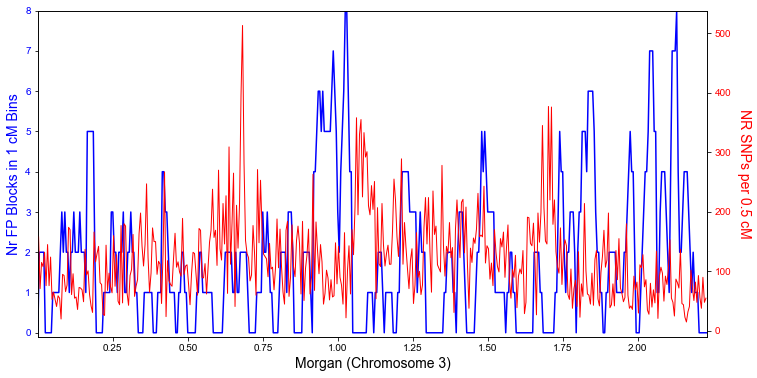

In [75]:
plot_fp_rate(m, bins10, counts)

# Analyze some true data

Loaded 18441 map positions
Filtered to 3617 IBD blocks on Chromosome 19
> 20 cM: 98/3617
Of these Min SNPs per cM> 0:               98/98


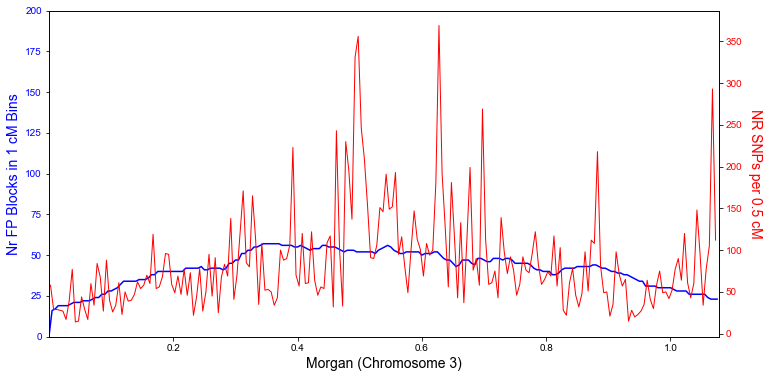

In [17]:
ch=19 #  ch1 ch10 problematic in terms of SNP density. ch8 really good
path_h5=f'./data/hdf5/1240k_v43/ch{ch}.h5'
m = load_map(path_h5=path_h5)
snp_cm=0

path_save = "/n/groups/reich/hringbauer/git/yamnaya/output/ibd/v43/ch_all.tsv" # for IBD csv file
df_ibd = pd.read_csv(path_save, sep="\t")
df_ibd = df_ibd[df_ibd["ch"]==ch].reset_index(drop=True)
print(f"Filtered to {len(df_ibd)} IBD blocks on Chromosome {ch}")

df_ibd=post_process_roh_df(df_ibd, min_cm=20, snp_cm=snp_cm, output=True)

bins10, counts = create_counts(df_ibd, m, bin_width=0.005)

plot_fp_rate(m, bins10, counts, ylim=[-0.1, 200])

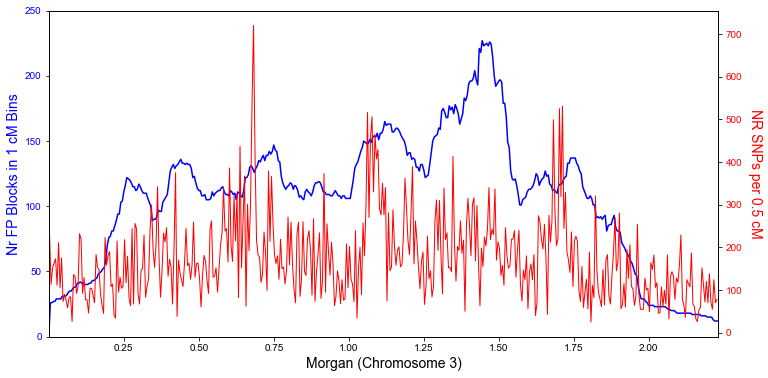

# Area 51

In [228]:
(df_ibd["End"]-df_ibd["Start"].values == df_ibd["length"].values).all()

True

In [229]:
df_ibd["length"]

25861    4109
25863    8466
25864    6996
25865    4710
25871    2647
         ... 
31517    5091
31520    9537
31528    3433
31532    2594
31533    8029
Name: length, Length: 1980, dtype: int64